# Audio Transcription

This notebook walks you through using an AI-powered Agent to transcribe and diarize audio files. The Agent automatically converts speech to text while distinguishing between different speakers

### Example Workflow

The following workflow illustrates how audio files can be pre-labeled. The code in this notebook is for the `Diarization` agent.


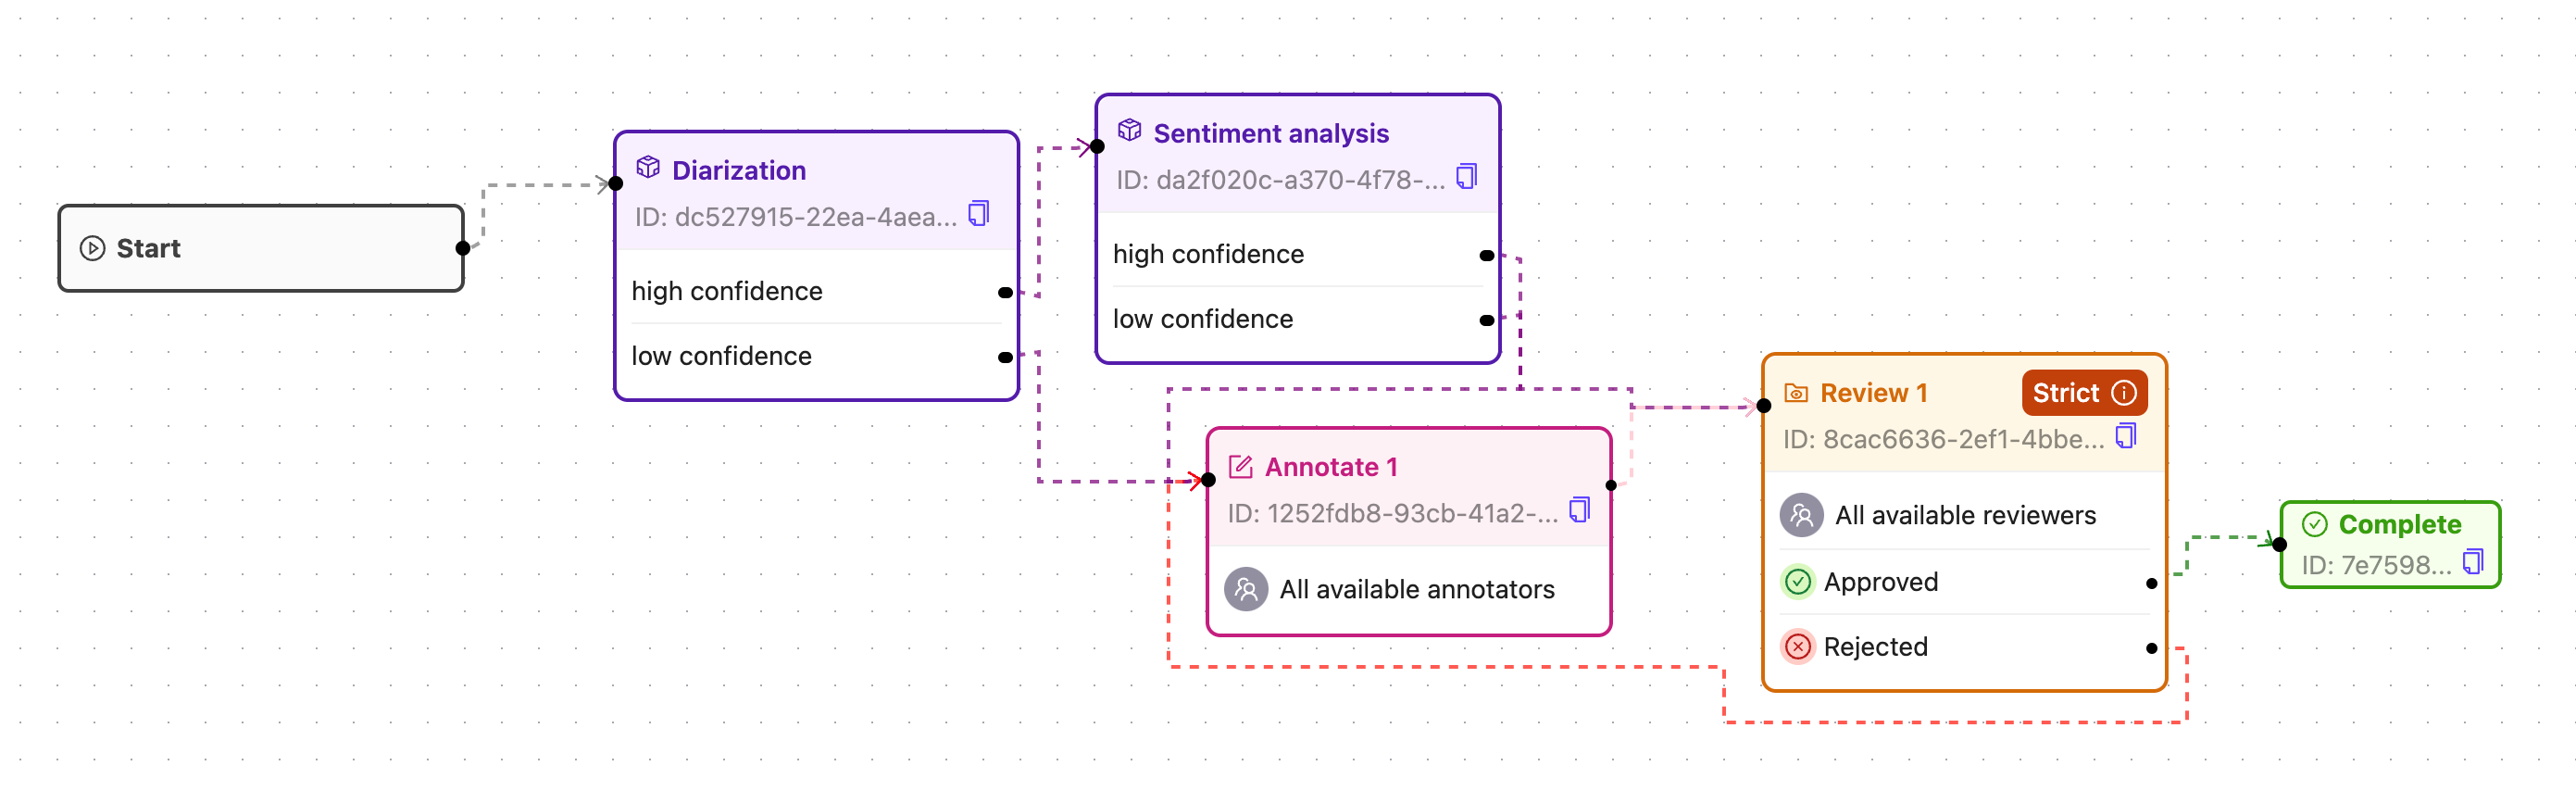

### Installation

Ensure that you install:
- The `encord-agents` library.
- `pyannote.audio`: A deep learning-based toolkit for speaker diarization, used to identify and differentiate speakers in an audio file.  
- `transformers & accelerate`: Hugging Face libraries used for running and optimizing transformer models, which improve transcription accuracy and performance.

In [ ]:
!python -m pip install -q encord-agents "pyannotate.audio"
!python -m pip install --upgrade -q transformers accelerate

### Hugging Face Authentication

Retrieve the Hugging Face API token for authentication when accessing models and datasets. A HF token (Hugging Face token) is an authentication key used to access Hugging Face's models, datasets, and APIs.

> 💡 In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks. IF YOU ARE NOT RUNNING THE CODE IN THE COLLAB NOTEBOOK, you must set the environment variable directly.
> ```python
> hf_token = "my-hf-token"
> ```

In [ ]:
from google.colab import userdata

hf_token = userdata.get("HF_TOKEN")

Please log in to HuggingFace and accept the terms of these two models:  

- <a href="https://huggingface.co/pyannote/speaker-diarization-3.1" target="_blank" rel="noopener noreferrer">Speaker diarization</a>
- <a href="https://huggingface.co/pyannote/segmentation" target="_blank" rel="noopener noreferrer">Audio segmentation</a>

Otherwise, the models will resist to run below.

Defines data structures and imports necessary libraries for audio transcription and speaker diarization.

- `Segment`: Represents a time segment in an audio file.
- `Diary`: Stores diarization results, including the speaker and transcribed text.
- `Diarization`: A structured model to hold multiple diarized segments and retrieve unique speakers.
- Imports necessary libraries for deep learning, audio processing, and transcription.

In [ ]:
from pathlib import Path
from typing import List, Optional, Union

import numpy as np
import requests
import torch
from encord.objects.frames import Range
from pyannote.audio import Pipeline
from pyannote.core.annotation import Annotation
from pydantic import BaseModel, RootModel
from sympy.physics.units import length
from torchaudio import functional as F
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from transformers.pipelines.audio_utils import ffmpeg_read


class Segment(BaseModel):
    start: float
    end: float

    @property
    def encord_range(self) -> Range:
        return Range(int(0.5 + self.start * 1000), int(0.5 + self.end * 1000))


class Diary(BaseModel):
    segment: Segment
    speaker: str
    text: str = ""


class Diarization(RootModel):
    root: List[Diary]

    @property
    def speakers(self) -> List[str]:
        return sorted(list(set([diary.speaker for diary in self.root])))

Defines the `Diarizer` class for speaker diarization and transcription.

- **Initialization (`__init__`)**: Loads pretrained models for diarization and transcription, setting up processing pipelines.
- **Preprocessing (`preprocess`)**: Converts audio files into a format suitable for diarization and transcription.
- **Segment Merging (`prepare_segments`)**: Combines consecutive segments from the same speaker into a single segment.
- **Transcription (`transcribe_segments`)**: Uses Whisper to transcribe diarized segments in batches.
- **Full Pipeline (`diarize_and_transcribe`)**: Runs diarization and transcription on an audio file, returning structured speaker-labeled transcripts.

In [ ]:
class Diarizer:
    def __init__(
        self,
        diarizer_model: str = "pyannote/speaker-diarization-3.1",
        transcription_model: str = "openai/whisper-medium",
    ):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Diarization
        self.diarization_pipeline = Pipeline.from_pretrained(diarizer_model, use_auth_token=hf_token).to(self.device)

        # Transcription
        processor = AutoProcessor.from_pretrained(transcription_model)
        self.sampling_rate = processor.feature_extractor.sampling_rate

        self.whisper_pipeline = pipeline(
            "automatic-speech-recognition",
            model=transcription_model,
            chunk_length_s=30,
        )

    def preprocess(self, inputs):
        with open(inputs, "rb") as f:
            inputs = f.read()

        if isinstance(inputs, bytes):
            inputs = ffmpeg_read(inputs, self.sampling_rate).copy()

        if len(inputs.shape) != 1:
            print("We expect a single channel audio input for ASRDiarizePipeline so we downmix")
            inputs = np.mean(inputs, axis=0, keepdims=True)

        torch_batch_input = torch.from_numpy(inputs).to(torch.float32)[None]
        return inputs, {"waveform": torch_batch_input, "sample_rate": self.sampling_rate}

    @staticmethod
    def prepare_segments(diarization: Annotation) -> Diarization:
        """
        Diarizer output may contain consecutive segments from the same speaker (e.g. {(0 -> 1, speaker_1), (1 -> 1.5, speaker_1), ...})
        we combine these segments to give overall timestamps for each speaker's turn (e.g. {(0 -> 1.5, speaker_1), ...})
        """

        segments = []
        for segment, track, label in diarization.itertracks(yield_label=True):
            segments.append({"segment": {"start": segment.start, "end": segment.end}, "label": label})

        new_segments = []
        prev_segment = cur_segment = segments[0]

        for i in range(1, len(segments)):
            cur_segment = segments[i]
            if cur_segment["label"] != prev_segment["label"] and i < len(segments):
                new_segments.append(
                    {
                        "segment": {"start": prev_segment["segment"]["start"], "end": cur_segment["segment"]["start"]},
                        "speaker": prev_segment["label"],
                    }
                )
                prev_segment = segments[i]

        new_segments.append(
            {
                "segment": {"start": prev_segment["segment"]["start"], "end": cur_segment["segment"]["end"]},
                "speaker": prev_segment["label"],
            }
        )
        return Diarization.model_validate(new_segments)

    def transcribe_segments(self, diaries: Diarization, inputs: np.ndarray, batch_size: int = 10):
        batch = []
        start_index = 0
        for index, diary in enumerate(diaries.root):
            audio_segment_start = int(self.sampling_rate * diary.segment.start)
            audio_segment_end = int(self.sampling_rate * diary.segment.end)
            segment_audio = inputs[audio_segment_start:audio_segment_end]
            if len(batch) < batch_size:
                batch.append(segment_audio)
                continue

            predicted = self.whisper_pipeline(batch)
            for pred, segment in zip(predicted, diaries.root[start_index : start_index + len(batch)]):
                segment.text = pred.get("text", "")

            batch = []
            start_index = index + 1

        if batch:
            predicted = self.whisper_pipeline(batch)
            for pred, segment in zip(predicted, diaries.root[start_index : start_index + len(batch)]):
                segment.text = pred.get("text", "")

        return diaries

    def diarize_and_transcribe(self, audio_file: Path | str):
        """
        Algo:
        1. Diarize => Sections of the audiofile with a "speaker stamp"
        2. For each section: Transcribe
        """
        # apply the pipeline to an audio file
        audio_file = audio_file if isinstance(audio_file, str) else audio_file.as_posix()
        transcription_input, diarization_input = self.preprocess(audio_file)
        diarization = self.diarization_pipeline(diarization_input)
        diary = self.prepare_segments(diarization)
        diary = self.transcribe_segments(diary, transcription_input)
        return diary


diarizer = Diarizer()
# diary = diarizer.diarize_and_transcribe("test_227.wav")

### Encord Authentication

Encord uses ssh-keys for authentication. The following is a code cell for setting the `ENCORD_SSH_KEY` environment variable. It contains the raw content of your private ssh key file.

If you have not setup an ssh key, see our [documentation](https://agents-docs.encord.com/authentication/).

> 💡 In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks. IF YOU ARE NOT RUNNING THE CODE IN THE COLLAB NOTEBOOK, you must set the environment variable directly.
> ```python
> os.environ["ENCORD_SSH_KEY"] = """paste-private-key-here"""
> ```

In [ ]:
import os

from google.colab import userdata

os.environ["ENCORD_SSH_KEY"] = userdata.get("ENCORD_SSH_KEY")

### Imports and Initialization

1. The Runner is initialized with a project hash, which allows interaction with an Encord project. Ensure that you replace <project-hash> with the ID of your Encord Project.

2. The code filters objects from the project's ontology structure based on two criteria:
  - The object must be of type Shape.AUDIO (audio object).
  - The object's title must contain the word "speaker" (case-insensitive).
  - The object should have a nested _text_ classification named `"utterance"` in which the transcript will be stored.

3. The objects that meet the filtering criteria are stored.

In [ ]:
from pathlib import Path
from typing import Annotated

from encord.objects.attributes import TextAttribute
from encord.objects.common import Shape
from encord.objects.coordinates import AudioCoordinates
from encord.objects.frames import Range
from encord.objects.ontology_labels_impl import LabelRowV2

from encord_agents.tasks import Depends, Runner
from encord_agents.tasks.dependencies import dep_asset

runner = Runner(project_hash="<project-hash>")
speakers = [
    o for o in runner.project.ontology_structure.objects if o.shape == Shape.AUDIO and "speaker" in o.title.lower()
]

### Define functions

The following function creates the audio transcription annotations on the selected objects.  

In [ ]:
def annotate_transcription(diaries: Diarization, label_row: LabelRowV2) -> bool:
    speaker_lookup = dict(zip(diaries.speakers, speakers))
    added_any = False

    for diary in diaries.root:
        speaker_clf = speaker_lookup.get(diary.speaker)
        utterance_attr = speaker_clf.get_child_by_title("utterance", type_=TextAttribute)
        if speaker_clf is None:
            continue

        ins = speaker_clf.create_instance()
        ins.set_answer(diary.text, attribute=utterance_attr)
        ins.set_for_frames(coordinates=AudioCoordinates(range=[diary.segment.encord_range]))
        label_row.add_object_instance(ins)
        added_any = True
    return added_any

Define the diarization function for speaker identification and transcription, and call the `annotate_transcription` function defined above.

In [ ]:
@runner.stage("Diarization")
def do_diarization(label_row: LabelRowV2, asset: Annotated[Path, Depends(dep_asset)]):
    diaries = diarizer.diarize_and_transcribe(asset)
    if annotate_transcription(diaries, label_row):
        label_row.save()
        return "high confidence"
    else:
        return "low confidence"

## Run the agent

Initialize the runner and set the task_batch_size to 1.



In [ ]:
runner(task_batch_size=1)

> 💡*Hint:* If you execute this as a Python script, you can run it as a command line interface by putting the above code in an `agents.py` file and replacing
> ```python
> runner()
> ```
> with
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```
> Which allows you to set, for example the Project hash using the command line:
> ```bash
> python agent.py --project-hash "..."
> ```


## Next steps

You can do [sentiment analysis](../audio_transcription_agent_multi_speaker/) on your transcriptions.

## What to do in case of installation errors

If the following error occures during installation:

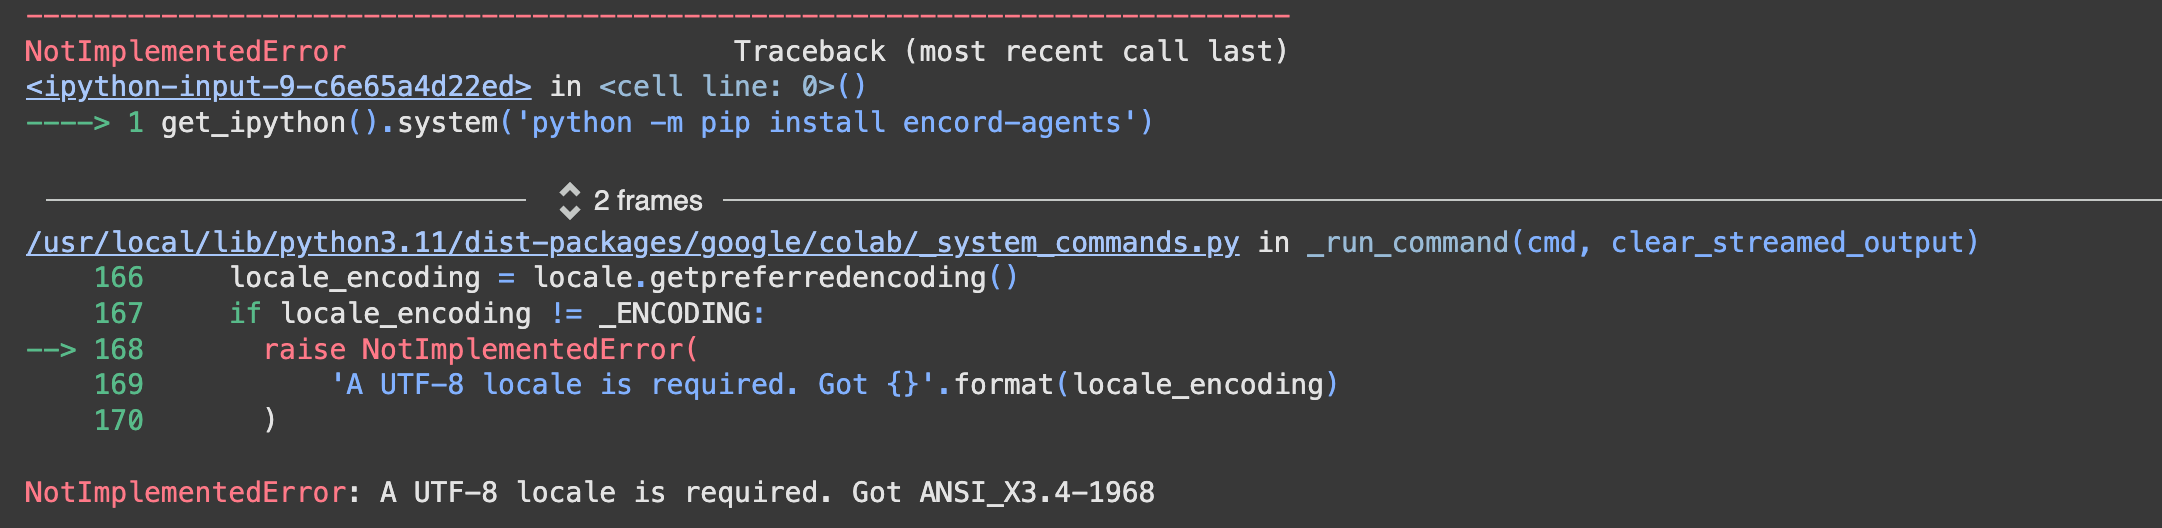

Try running the code cell below before installing again.
It typically happens at the later installs.

In [ ]:
import locale


def getpreferredencoding(do_setlocale=True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding